Importation des modules

In [1]:
#pip install -r requirements.txt

Inférence

device: cpu


100%|██████████| 50/50 [13:31<00:00, 16.24s/it]


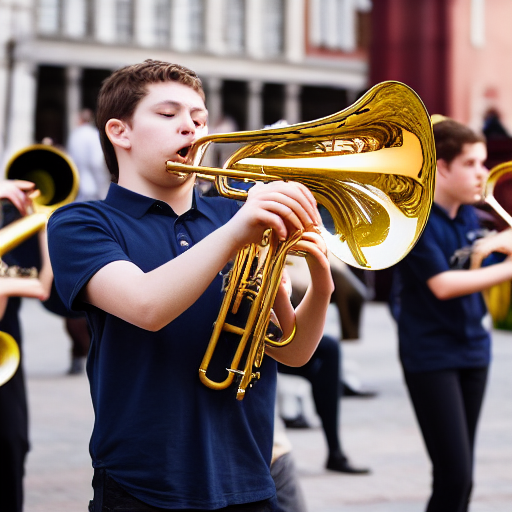

In [ ]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"

print(f"device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

prompt = "A cat jumping over a fence, highly detailed, ultra sharp, cinematic, 8k resolution, 100mm lens."
uncond_prompt = ""  #Prompt négatif
do_cfg = True
cfg_scale = 8  # entre 1 et 14, indique a quel point l'IA va faire attention au prompt

## IMAGE TO IMAGE

input_image = None
image_path = "../images/castle on a hill modifie - eclairs.png"
#Décommenter pour faire la diffusion image a image
#input_image = Image.open(image_path)

#Quantité de bruit ajouté à l'image (entre 0 et 1). Plus il y a de bruit et plus l'IA pourra modifier l'image
strength = 0.5

## SAMPLER
sampler = "ddpm"
n_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=n_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Affiche l'image obtenue
Image.fromarray(output_image)

"for i in range(len(noise_imgs)):\n    display_img = Image.fromarray(noise_imgs[i].squeeze(0).numpy(), 'RGB')\n    display_img.show()"

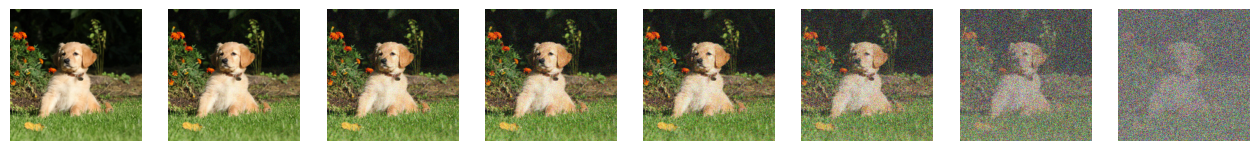

In [3]:
from ddpm import DDPMSampler

from PIL import Image
from matplotlib import pyplot as plt
import torch
import numpy as np
import math

generator = torch.Generator()
generator.manual_seed(0)

ddpm_sampler = DDPMSampler(generator)

# How many noise levels to generate
noise_levels = [0, 10, 50, 75, 100, 250, 500, 750]

img = Image.open("../images/dog.jpg")
img_tensor = torch.tensor(np.array(img))
img_tensor = ((img_tensor / 255.0) * 2.0) - 1.0
# Create a batch by repeating the same image many times
batch = img_tensor.repeat(len(noise_levels), 1, 1, 1)

ts = torch.tensor(noise_levels, dtype=torch.int, device=batch.device)
noise_imgs = []
epsilons = torch.randn(batch.shape, device=batch.device)
# Generate a noisifed version of the image for each noise level
for i in range(len(ts)):
    a_hat = ddpm_sampler.alphas_cumprod[ts[i]]
    noise_imgs.append(
        (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
    )


noise_imgs = torch.stack(noise_imgs, dim=0)
noise_imgs = (noise_imgs.clamp(-1, 1) + 1) / 2
noise_imgs = (noise_imgs * 255).type(torch.uint8)


plt.figure(figsize=(16, 8))
for i in range(0, len(noise_imgs)):
    display_img = noise_imgs[i].squeeze(0).numpy()

    plt.subplot(1, len(noise_imgs), 1 + i)
    plt.imshow(display_img)
    plt.axis("off")
# Convert back to image and display
"""display_img = Image.fromarray(noise_imgs.squeeze(0).numpy(), 'RGB')
display_img"""
"""for i in range(len(noise_imgs)):
    display_img = Image.fromarray(noise_imgs[i].squeeze(0).numpy(), 'RGB')
    display_img.show()"""